In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Trajectoire MRU
def MRU_gen(length, T, x_0, n):
  # Vérification de la forme de x_0
  if x_0.shape != (2,):
      print("x_0 has not the shape (2,)")
      return np.empty((2,))  # Retourne un tableau vide si la condition échoue

  # Préallocation pour un tableau contenant toutes les étapes
  L = np.zeros((length + 1, 2))  # Préallouer un tableau pour tous les états
  L[0] = x_0  # Initialisation avec l'état initial

  # Paramètres de la simulation
  q = n * 9.81 * T
  Q = q * np.array([
      [T**3 / 3, T**2 / 2],
      [T**2 / 2, T]
  ])
  phi = np.array([
      [1, T],
      [0, 1]
  ])

  # Boucle principale
  R = np.linalg.cholesky(Q)  # Cholesky decomposition (invariant dans la boucle)
  for i in range(length):
      U = np.random.randn(2,)  # Génère un vecteur aléatoire
      B = R @ U  # Génère le bruit
      L[i + 1] = phi @ L[i] + B  # Calcule le nouvel état

  return L

In [3]:
# Trajectoire MUA
def MUA_gen(length, T, x_0, n):
  # Vérification de la forme de x_0
  if x_0.shape != (3,):
      print("x_0 has not the shape (3,)")
      return np.empty((3,))  # Retourne un tableau vide si la condition échoue

  # Préallocation pour un tableau contenant toutes les étapes
  L = np.zeros((length + 1, 3))  # Préallouer un tableau pour tous les états
  L[0] = x_0  # Initialisation avec l'état initial

  # Paramètres de la simulation
  q = n * 9.81 * T
  Q = q * np.array([
      [T**5 / 20, T**4 / 8, T**3 / 6],
      [T**4 / 8, T**3 / 3, T**2 / 2],
      [T**3 / 6, T**2 / 2, T]
  ])
  phi = np.array([
      [1, T, T**2 / 2],
      [0, 1, T],
      [0, 0, 1]
  ])

  # Boucle principale
  R = np.linalg.cholesky(Q)  # Cholesky decomposition (invariant dans la boucle)
  for i in range(length):
      U = np.random.randn(3,)  # Génère un vecteur aléatoire
      B = R @ U  # Génère le bruit
      L[i + 1] = phi @ L[i] + B  # Calcule le nouvel état

  return L

In [4]:
# Trajectoire Singer
def Singer_gen(length, T, x_0,alpha,sigma_m ):
  L=[]
  L.append(x_0)  # Ensure x_0 is a column vector
  q11 = (1 / (2 * alpha ** 5)) * (
              2 * alpha * T - 2 * alpha ** 2 * T ** 2 + 2 * alpha ** 3 * T ** 3 / 3 - 4 * alpha * T * np.exp(
          -alpha * T) - np.exp(-2 * alpha * T) + 1)
  q12 = (1 / (2 * alpha ** 4)) * (alpha ** 2 * T ** 2 + 1 + np.exp(-2 * alpha * T) + np.exp(-alpha * T) * (-2 + 2 * alpha * T)- 2 * alpha * T)
  q13 = (1 / (2 * alpha ** 3)) * (1 - 2 * alpha * T * np.exp(-alpha * T) - np.exp(-2 * alpha * T))
  q22 = (1 / (2 * alpha ** 3)) * (2 * alpha * T - 3 + 4 * np.exp(-alpha * T) - np.exp(-2 * alpha * T))
  q23 = (1 / (2 * alpha ** 2)) * (1 - np.exp(-alpha * T)) ** 2
  q33 = -(1 / (2 * alpha)) * (np.exp(-2 * alpha * T) - 1)

  Q = 2*alpha*sigma_m**2 * np.array([
      [q11, q12, q13],
      [q12, q22, q23],
      [q13,  q23, q33]
  ])
  phi = np.array([[1, T, (1 / alpha ** 2) * (-1 + alpha * T + np.exp(-alpha * T))],
                  [0, 1, (1 / alpha) * (1 - np.exp(-alpha * T))],
                  [0, 0, np.exp(-alpha * T)]])
  for i in range(length):
      U = np.random.randn(3, 1)  # Generate a random vector
      R = np.linalg.cholesky(Q)  # Cholesky decomposition
      B = R.T @ U         # Generate the noise vector
      #print(B)
      # Update x with the new state

      x_new  =phi @ L[-1] + B
      L.append(x_new)

  return L

In [5]:
# Add Noise with SNR Control
def add_noise_with_snr(trajectory, snr_db):
    """
    Add Gaussian noise to a trajectory to achieve a specific SNR.
    Args:
    - trajectory (np.ndarray): Original trajectory.
    - snr_db (float): Desired SNR in dB.
    Returns:
    - np.ndarray: Noisy trajectory with the specified SNR.
    """
    signal_power = np.mean(trajectory**2)
    snr_linear = 10**(snr_db / 10)
    noise_power = signal_power / snr_linear
    noise_std = np.sqrt(noise_power)
    noise = np.random.normal(0, noise_std, size=trajectory.shape)
    return trajectory + noise

Generated 29988 trajectories.
Autocorrelation Features Shape: torch.Size([299880, 10])
Acceleration Features Shape: torch.Size([299880, 10])
Labels Shape: torch.Size([299880])
Dataset Balance:
  mru: 99990
  mua: 99990
  singer: 99900


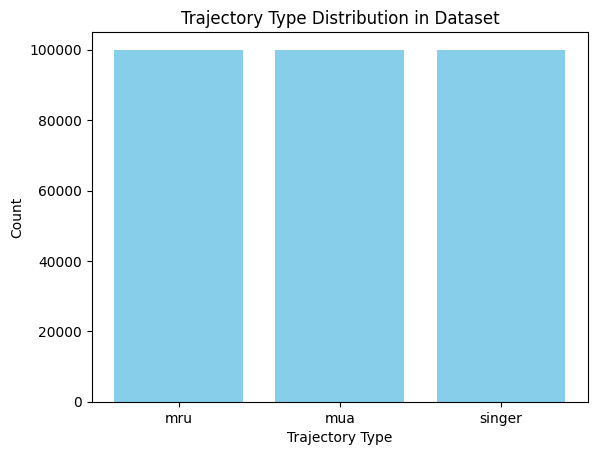

In [6]:
import numpy as np
import torch

# Label Mapping and Window Size
label_mapping = {'mru': 0, 'mua': 1, 'singer': 2}
window_size = 10
fixed_snr_db = 100  # Fixed SNR

# Feature Computation Functions
def estimate(X_pos):
    """
    Estimate velocity and acceleration from position data (X_pos).
    """
    X_vit = []
    X_acc = []

    for i in range(len(X_pos) - 2):
        vit = X_pos[i + 1] - X_pos[i]  # Velocity
        acc = X_pos[i + 2] - 2 * X_pos[i + 1] + X_pos[i]  # Acceleration
        X_vit.append(vit)
        X_acc.append(acc)

    # Handle edge cases for velocity and acceleration
    X_vit.insert(0, X_pos[1] - X_pos[0])  # First velocity
    X_vit.append(X_pos[-1] - X_pos[-2])  # Last velocity
    X_acc.insert(0, X_pos[2] - 2 * X_pos[1] + X_pos[0])  # First acceleration
    X_acc.append(X_pos[-1] - 2 * X_pos[-2] + X_pos[-3])  # Last acceleration

    return np.array(X_vit), np.array(X_acc)

def compute_windowed_autocorr_est(X_pos, window_size):
    """
    Compute windowed autocorrelation and acceleration for the given trajectory.
    """
    _, acc_est = estimate(X_pos)  # Get acceleration

    autocorr_list, accel_windows = [], []

    for i in range(0, len(acc_est) - window_size + 1, window_size):
        window = acc_est[i:i + window_size]
        accel_windows.append(window)

        # Compute autocorrelation
        corr = np.correlate(window, window, mode="full")
        autocorr = corr[len(window) - 1:]  # Keep positive lag only

        # Normalize by max value
        if np.max(np.abs(autocorr)) > 0:
            autocorr /= np.max(np.abs(autocorr))

        autocorr_list.append(autocorr)

    # Convert to tensors
    autocorr_tensor = torch.tensor(np.array(autocorr_list, dtype=np.float32))
    accel_tensor = torch.tensor(np.array(accel_windows, dtype=np.float32))

    return autocorr_tensor, accel_tensor

# Trajectory Generators
def generate_mru_trajectory(length, T):
    x_0 = np.random.uniform(-1, 1, size=(2,))  # Random initial position and velocity
    trajectory = MRU_gen(length, T, x_0, n=1.0)  # Replace MRU_gen with your implementation
    return add_noise_with_snr(trajectory, fixed_snr_db)  # Apply noise

def generate_mua_trajectory(length, T):
    x_0 = np.random.uniform(-1, 1, size=(3,))  # Random initial state
    trajectory = MUA_gen(length, T, x_0, n=1.0)  # Replace MUA_gen with your implementation
    return add_noise_with_snr(trajectory, fixed_snr_db)  # Apply noise

def generate_singer_trajectory(length, T, alpha, sigma_m):
    x_0 = np.random.randn(3, 1)  # Random initial state
    trajectory = Singer_gen(length, T, x_0, alpha=alpha, sigma_m=sigma_m)
    trajectory = np.array([state.flatten() for state in trajectory])  # Flatten trajectory
    return add_noise_with_snr(trajectory, fixed_snr_db)  # Apply noise

# Dataset Generation
T = 1.0  # Fixed time step
num_trajectories_per_type = 10000  # Total trajectories per type
length_values = [50, 100, 150]  # Varying lengths for each trajectory type
alpha_values = [0.1, 0.2, 0.3]  # For Singer
sigma_m_values = [0.5, 1.0]  # For Singer

trajectories = []
trajectories_per_length = num_trajectories_per_type // len(length_values)

# Generate MRU Trajectories
for _ in range(trajectories_per_length):
    for length in length_values:
        trajectories.append({'type': 'mru', 'trajectory': generate_mru_trajectory(length, T)})

# Generate MUA Trajectories
for _ in range(trajectories_per_length):
    for length in length_values:
        trajectories.append({'type': 'mua', 'trajectory': generate_mua_trajectory(length, T)})

# Generate Singer Trajectories
for _ in range(trajectories_per_length // (len(alpha_values) * len(sigma_m_values))):
    for length in length_values:
        for alpha in alpha_values:
            for sigma_m in sigma_m_values:
                trajectories.append({'type': 'singer', 'trajectory': generate_singer_trajectory(length, T, alpha, sigma_m)})

print(f"Generated {len(trajectories)} trajectories.")

# Process Features and Labels
autocorr_features, accel_features, labels = [], [], []

for traj in trajectories:
    traj_type = traj['type']
    X_pos = np.array(traj['trajectory'])[:, 0]  # Extract x-axis for simplicity

    # Skip short or invalid trajectories
    if len(X_pos) < window_size + 2:
        print(f"Skipping short trajectory for {traj_type}. Length: {len(X_pos)}")
        continue

    # Compute autocorrelation and acceleration
    autocorr, accel = compute_windowed_autocorr_est(X_pos, window_size)

    if autocorr.shape[0] == 0 or accel.shape[0] == 0:
        print(f"Skipping invalid trajectory for {traj_type}.")
        continue

    # Append features and labels
    autocorr_features.append(autocorr)
    accel_features.append(accel)
    labels.extend([label_mapping[traj_type]] * autocorr.shape[0])  # Match window count

# Convert features and labels to tensors
autocorr_features = torch.cat(autocorr_features)
accel_features = torch.cat(accel_features)
labels = torch.tensor(labels, dtype=torch.long)

# Debug final shapes
print(f"Autocorrelation Features Shape: {autocorr_features.shape}")
print(f"Acceleration Features Shape: {accel_features.shape}")
print(f"Labels Shape: {labels.shape}")

from collections import Counter

# Count occurrences of each label in the dataset
label_counts = Counter(labels.numpy())  # Convert labels tensor to numpy array for counting

# Display the counts of each trajectory type
print("Dataset Balance:")
for label, count in label_counts.items():
    traj_type = [key for key, value in label_mapping.items() if value == label][0]
    print(f"  {traj_type}: {count}")

# Visualize the balance with a bar chart
import matplotlib.pyplot as plt

labels_names = [key for key in label_mapping.keys()]
counts = [label_counts[label_mapping[name]] for name in labels_names]

plt.bar(labels_names, counts, color='skyblue')
plt.title("Trajectory Type Distribution in Dataset")
plt.xlabel("Trajectory Type")
plt.ylabel("Count")
plt.show()



Autocorr Features Shape: torch.Size([299880, 10])
Accel Features Shape: torch.Size([299880, 10])
Labels Shape: torch.Size([299880])
Epoch 1/7, Train Loss: 0.0872, Train Acc: 96.69%, Test Loss: 0.0694, Test Acc: 97.50%
Epoch 2/7, Train Loss: 0.0692, Train Acc: 97.54%, Test Loss: 0.0700, Test Acc: 97.52%
Epoch 3/7, Train Loss: 0.0669, Train Acc: 97.56%, Test Loss: 0.0662, Test Acc: 97.60%
Epoch 4/7, Train Loss: 0.0648, Train Acc: 97.64%, Test Loss: 0.0662, Test Acc: 97.66%
Epoch 5/7, Train Loss: 0.0640, Train Acc: 97.67%, Test Loss: 0.0651, Test Acc: 97.65%
Epoch 6/7, Train Loss: 0.0637, Train Acc: 97.67%, Test Loss: 0.0646, Test Acc: 97.67%
Epoch 7/7, Train Loss: 0.0628, Train Acc: 97.68%, Test Loss: 0.0671, Test Acc: 97.60%


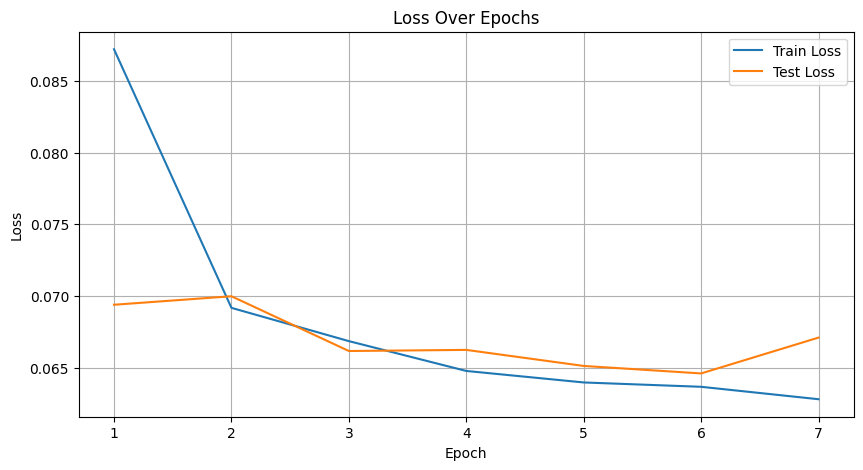

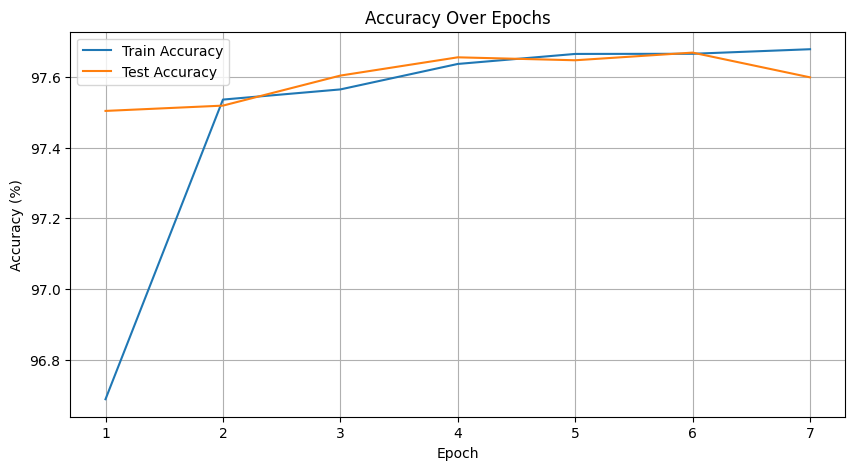

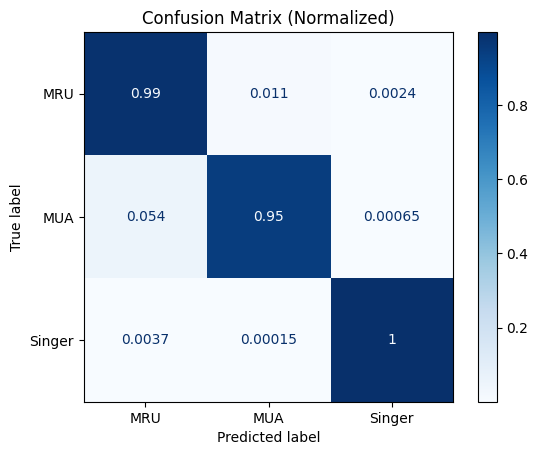

Classification Report:
              precision    recall  f1-score   support

         MRU       0.95      0.99      0.97     20104
         MUA       0.99      0.95      0.97     19921
      Singer       1.00      1.00      1.00     19951

    accuracy                           0.98     59976
   macro avg       0.98      0.98      0.98     59976
weighted avg       0.98      0.98      0.98     59976



In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

print(f"Autocorr Features Shape: {autocorr_features.shape}")
print(f"Accel Features Shape: {accel_features.shape}")
print(f"Labels Shape: {labels.shape}")

# Dataset Class
class TrajectoryDataset(Dataset):
    def __init__(self, autocorr_features, accel_features, labels):
        """
        Initialize the dataset with features and labels.
        """
        # Combine autocorrelation and acceleration as channels
        self.features = torch.stack((autocorr_features, accel_features), dim=1)  # Shape: (num_samples, 2, window_size)
        self.labels = labels

    def __len__(self):
        """
        Return the total number of samples in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieve a sample by index.
        """
        return {
            'features': self.features[idx],  # Shape: (2, window_size)
            'label': self.labels[idx]        # Corresponding label
        }

# CNN Model
class TrajectoryCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(TrajectoryCNN, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(32 * 5, 64)  # Adjust based on input size
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layer
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


# Create a permutation of indices for shuffling
indices = torch.randperm(len(labels))  # Random permutation of indices

# Apply the permutation to shuffle the features and labels
autocorr_features = autocorr_features[indices]
accel_features = accel_features[indices]
labels = labels[indices]

# Split data into training and test sets (80% train, 20% test)
train_size = int(0.8 * len(labels))
test_size = len(labels) - train_size

train_dataset = TrajectoryDataset(autocorr_features[:train_size], accel_features[:train_size], labels[:train_size])
test_dataset = TrajectoryDataset(autocorr_features[train_size:], accel_features[train_size:], labels[train_size:])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model Initialization
input_channels = 2  # Combined autocorrelation and acceleration as channels
num_classes = 3  # Number of trajectory types
model = TrajectoryCNN(input_channels, num_classes)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 7
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    for batch in train_loader:
        features = batch['features']  # Shape: (batch_size, input_channels, window_size)
        labels = batch['label']

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    # Testing
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            features = batch['features']  # Shape: (batch_size, input_channels, window_size)
            labels = batch['label']
            outputs = model(features)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect predictions and labels
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * correct / total)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
          f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.2f}%")

# Visualize Training and Test Results
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Compute Confusion Matrix
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

cm = confusion_matrix(all_labels, all_predictions, labels=[0, 1, 2])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['MRU', 'MUA', 'Singer'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Normalized)")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=['MRU', 'MUA', 'Singer']))


In [8]:
# Initialize a counter
batch_counter = 0

# Loop through the train_loader
for batch in train_loader:
    features = batch['features']
    labels = batch['label']
    outputs = model(features)
    predicted = torch.argmax(outputs, dim=1)

    print(f"Batch {batch_counter + 1}:")
    print(f"Predicted: {predicted}")
    print(f"Actual: {labels}")
    print("-" * 30)  # Separator for readability

    batch_counter += 1  # Increment the counter

    if batch_counter >= 10:  # Stop after checking 10 batches
        break



Batch 1:
Predicted: tensor([0, 2, 2, 2, 0, 0, 2, 1, 2, 2, 0, 1, 1, 0, 1, 2, 1, 2, 1, 1, 1, 0, 1, 0,
        1, 2, 1, 2, 1, 2, 1, 0, 2, 0, 1, 2, 0, 2, 2, 2, 2, 1, 0, 1, 0, 1, 1, 0,
        1, 1, 0, 2, 1, 0, 1, 2, 2, 0, 2, 2, 0, 0, 1, 0])
Actual: tensor([0, 2, 2, 2, 0, 0, 2, 1, 2, 2, 0, 0, 1, 0, 1, 2, 1, 2, 1, 1, 1, 0, 1, 0,
        1, 2, 1, 2, 1, 2, 1, 0, 2, 0, 1, 2, 0, 2, 2, 2, 2, 1, 0, 1, 0, 1, 1, 0,
        1, 1, 0, 2, 1, 0, 1, 2, 0, 0, 2, 2, 0, 1, 1, 0])
------------------------------
Batch 2:
Predicted: tensor([2, 0, 2, 1, 1, 0, 0, 0, 1, 0, 2, 0, 2, 2, 0, 1, 1, 1, 0, 2, 2, 0, 1, 2,
        0, 1, 1, 0, 2, 2, 1, 2, 2, 0, 0, 2, 2, 2, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0,
        1, 1, 1, 0, 2, 0, 2, 2, 1, 2, 0, 2, 0, 0, 2, 0])
Actual: tensor([2, 0, 2, 1, 1, 0, 0, 0, 1, 0, 2, 0, 2, 2, 0, 1, 1, 1, 0, 2, 2, 0, 1, 2,
        0, 1, 1, 0, 2, 2, 1, 2, 2, 0, 0, 2, 2, 2, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0,
        1, 1, 1, 0, 2, 0, 2, 2, 1, 2, 0, 2, 0, 0, 2, 0])
------------------------------
Batch 3:
Predi

In [9]:
print(f"Total Predictions: {len(all_predictions)}, Total Labels: {len(all_labels)}")
print(f"Test Dataset Size: {len(test_dataset)}")


Total Predictions: 59976, Total Labels: 59976
Test Dataset Size: 59976


In [10]:
from collections import Counter
print("Label Distribution in Test Set:", Counter(all_labels))

Label Distribution in Test Set: Counter({0: 20104, 2: 19951, 1: 19921})


In [11]:
print("Prediction Distribution in Test Set:", Counter(all_predictions))

Prediction Distribution in Test Set: Counter({0: 20970, 2: 19937, 1: 19069})
